## Applying Deep Learning to Structured Data

### In this example we leverage a Kaggle dataset based on the "home credit default risk" competiton which tries to predict how capable each applicant is of repaying a loan

* Our sole objective here is to show how deep learning can work with a structured dataset
* We used the base data provided and not all of the other datasets that were provided or any external data
* The approach followed here is based on [Entity Embeddings of categorical variables](http://www.arxiv.org/abs/1604.06737)
* It is adapted from fastai by Jeremy Howard
* Without any feature engineering and by only using base datasets we were able to get a AUC of ~0.75 by adapting deep learning approaches (specifically embedding matrices)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
cd ~/fastai

/home/paperspace/fastai


In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [4]:
# read in the training and test datasets from csv files
training_set=pd.read_csv('~/hcdr/application_train.csv')
test_set=pd.read_csv('~/hcdr/application_test.csv')

In [5]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [6]:
display(DataFrameSummary(training_set).summary())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511,307511,NaN,NaN,NaN,NaN,307511,307511,307511,307499,...,307511,307511,307511,307511,265992,265992,265992,265992,265992,265992
mean,278181,0.0807288,NaN,NaN,NaN,NaN,0.417052,168798,599026,27108.6,...,0.00812979,0.000595101,0.000507299,0.000334947,0.00640245,0.00700021,0.0343619,0.267395,0.265474,1.89997
std,102790,0.272419,NaN,NaN,NaN,NaN,0.722121,237123,402491,14493.7,...,0.0897982,0.0243875,0.0225176,0.0182985,0.0838491,0.110757,0.204685,0.916002,0.794056,1.86929
min,100002,0,NaN,NaN,NaN,NaN,0,25650,45000,1615.5,...,0,0,0,0,0,0,0,0,0,0
25%,189146,0,NaN,NaN,NaN,NaN,0,112500,270000,16524,...,0,0,0,0,0,0,0,0,0,0
50%,278202,0,NaN,NaN,NaN,NaN,0,147150,513531,24903,...,0,0,0,0,0,0,0,0,0,1
75%,367142,0,NaN,NaN,NaN,NaN,1,202500,808650,34596,...,0,0,0,0,0,0,0,0,0,3
max,456255,1,NaN,NaN,NaN,NaN,19,1.17e+08,4.05e+06,258026,...,1,1,1,1,4,9,8,27,261,25
counts,307511,307511,307511,307511,307511,307511,307511,307511,307511,307499,...,307511,307511,307511,307511,265992,265992,265992,265992,265992,265992
uniques,307511,2,2,3,2,2,15,2548,5603,13672,...,2,2,2,2,5,9,9,24,11,25


### We will define categorical variables as those variables in the dataset that are not 'float' and also have less than

### 150 unique levels. The remaining will be categorized as continuous variables

In [7]:
cat_vars = [col for col in training_set if training_set[col].dtype.name != 'float64' and training_set[col].dtype.name != 'float32' and len(training_set[col].unique()) < 150]

In [8]:
contin_vars= [col for col in training_set if not(col in cat_vars)]

In [9]:
print(f'we have {len(cat_vars)} categorical variables and {len(contin_vars)} continuous variables')

we have 53 categorical variables and 69 continuous variables


In [10]:
training_set['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [11]:
# remove the target (dependent) variable from the list of categorical variables
cat_vars.remove('TARGET')

In [12]:
# remove the ID variable from the list of continuous variables
contin_vars.remove('SK_ID_CURR')

In [13]:
# create the training set with target and ID 
dep='TARGET'
training_set=training_set[cat_vars+contin_vars+[dep,'SK_ID_CURR']]

In [18]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, NAME_CONTRACT_TYPE to SK_ID_CURR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [19]:
# create the test set and set dep to zero in this set
test_set[dep]=0
test_set=test_set[cat_vars+contin_vars+[dep,'SK_ID_CURR']]

In [21]:
# set the type of categorical variables to category
for v in cat_vars:
    training_set[v]=training_set[v].astype('category').cat.as_ordered()

In [22]:
# apply the training data template for categorical variables to test set as well
apply_cats(test_set, training_set)

In [23]:
# set continuous variable type to float32 as required by pytorch
for v in contin_vars:
    training_set[v]=training_set[v].astype('float32')
    test_set[v]=test_set[v].astype('float32')

In [24]:
training_set.shape

(307511, 122)

### Initial tests were run on samples which can be created as follows:

In [25]:
# we are going to run on a sample
idxs=get_cv_idxs(len(training_set),val_pct=1.0)
training_samp=training_set.iloc[idxs].set_index('SK_ID_CURR')
samp_size=len(training_samp)
samp_size
#training_samp.index

307511

In [26]:
training_samp.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384575,Cash loans,M,Y,N,2,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0.0,0.0,-2.0,0.0,0.0,0.0,1.0,0.0,1.0,0
214010,Cash loans,F,Y,Y,0,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,...,2.0,0.0,-1071.0,0.0,0.0,0.0,1.0,0.0,3.0,0


### Data frame procedure proc df in fastai is very versatile and does the following
* Pull out dependent variable separately and remove from original dataframe
* mapper will store the metrics required for scaling
* nas stores the mapping for missing values
  * for continuous variables replace w/ median and create a separate missing variable
  * for categorical variables replace missing w/ category 0

In [27]:
df,y,nas,mapper=proc_df(training_samp, 'TARGET', do_scale=True)

In [28]:
df.shape

(307511, 181)

In [29]:
test_set=test_set.set_index('SK_ID_CURR')

In [30]:
df_test, _,nas,mapper=proc_df(test_set, 'TARGET', do_scale=True, mapper=mapper, na_dict=nas)

In [31]:
df_test.shape

(48744, 181)

In [32]:
df.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DEF_30_CNT_SOCIAL_CIRCLE_na,OBS_60_CNT_SOCIAL_CIRCLE_na,DEF_60_CNT_SOCIAL_CIRCLE_na,DAYS_LAST_PHONE_CHANGE_na,AMT_REQ_CREDIT_BUREAU_HOUR_na,AMT_REQ_CREDIT_BUREAU_DAY_na,AMT_REQ_CREDIT_BUREAU_WEEK_na,AMT_REQ_CREDIT_BUREAU_MON_na,AMT_REQ_CREDIT_BUREAU_QRT_na,AMT_REQ_CREDIT_BUREAU_YEAR_na
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
384575,1,2,2,1,3,7,2,5,2,2,...,-0.057717,-0.057717,-0.057717,-0.001803,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
214010,1,1,2,2,1,7,2,2,4,2,...,-0.057717,-0.057717,-0.057717,-0.001803,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084


In [33]:
df_test.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DEF_30_CNT_SOCIAL_CIRCLE_na,OBS_60_CNT_SOCIAL_CIRCLE_na,DEF_60_CNT_SOCIAL_CIRCLE_na,DAYS_LAST_PHONE_CHANGE_na,AMT_REQ_CREDIT_BUREAU_HOUR_na,AMT_REQ_CREDIT_BUREAU_DAY_na,AMT_REQ_CREDIT_BUREAU_WEEK_na,AMT_REQ_CREDIT_BUREAU_MON_na,AMT_REQ_CREDIT_BUREAU_QRT_na,AMT_REQ_CREDIT_BUREAU_YEAR_na
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,1,1,2,1,7,8,2,2,2,...,-0.057717,-0.057717,-0.057717,-0.001803,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084
100005,1,2,1,2,1,7,8,5,2,2,...,-0.057717,-0.057717,-0.057717,-0.001803,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084,-0.395084


In [35]:
# define validation_set as last 25% of rows sorted by index
train_ratio=0.75
train_size=int(samp_size*train_ratio)
val_idx=list(range(train_size, len(df)))
train_size

230633

### Columnar Model Data Object can be created for structured data
* path as to where to save files etc
* validation indices
* name of dataframe input
* dependent y
* identify categorical variables
* batch size
* Is this regression vs classification
* specify test dataset

In [36]:
md=ColumnarModelData.from_data_frame('~/hcdr', val_idx, df, y.astype('int32'), cat_flds=cat_vars, bs=128, is_reg=False, test_df=df_test)

### Embedding matrices for categorical variables. A typical way categorical variables are dealt with is via one hot encoding so e.g. if the variable is "marital status" and has the following levels--married, single, divorced. One hot encoding would essentially code each one as a 1 with the others being 0. 

### WIth embedding matrices let us say we can represent the variable with 2 embeddings so we will have a 3X2 embedding matrix with random values (initially). Richer concept the one hot encoding and allows for concepts in multi dimensional space as opposed to OHE which is uni-dimensional

### For efficiency purposes, the value of the variable is stored as an index (e.g. 0,1,2 for the three levels) and a lookup is done to grab the appropriate row from the embedding matrix

In [37]:
cat_sz=[(c,len(training_samp[c].cat.categories)+1) for c in cat_vars]

In [38]:
cat_sz

[('NAME_CONTRACT_TYPE', 3),
 ('CODE_GENDER', 4),
 ('FLAG_OWN_CAR', 3),
 ('FLAG_OWN_REALTY', 3),
 ('CNT_CHILDREN', 16),
 ('NAME_TYPE_SUITE', 8),
 ('NAME_INCOME_TYPE', 9),
 ('NAME_EDUCATION_TYPE', 6),
 ('NAME_FAMILY_STATUS', 7),
 ('NAME_HOUSING_TYPE', 7),
 ('FLAG_MOBIL', 3),
 ('FLAG_EMP_PHONE', 3),
 ('FLAG_WORK_PHONE', 3),
 ('FLAG_CONT_MOBILE', 3),
 ('FLAG_PHONE', 3),
 ('FLAG_EMAIL', 3),
 ('OCCUPATION_TYPE', 19),
 ('REGION_RATING_CLIENT', 4),
 ('REGION_RATING_CLIENT_W_CITY', 4),
 ('WEEKDAY_APPR_PROCESS_START', 8),
 ('HOUR_APPR_PROCESS_START', 25),
 ('REG_REGION_NOT_LIVE_REGION', 3),
 ('REG_REGION_NOT_WORK_REGION', 3),
 ('LIVE_REGION_NOT_WORK_REGION', 3),
 ('REG_CITY_NOT_LIVE_CITY', 3),
 ('REG_CITY_NOT_WORK_CITY', 3),
 ('LIVE_CITY_NOT_WORK_CITY', 3),
 ('ORGANIZATION_TYPE', 59),
 ('FONDKAPREMONT_MODE', 5),
 ('HOUSETYPE_MODE', 4),
 ('WALLSMATERIAL_MODE', 8),
 ('EMERGENCYSTATE_MODE', 3),
 ('FLAG_DOCUMENT_2', 3),
 ('FLAG_DOCUMENT_3', 3),
 ('FLAG_DOCUMENT_4', 3),
 ('FLAG_DOCUMENT_5', 3),
 ('FL

In [39]:
emb_szs=[(c,min(50,(c+1)//2)) for _,c in cat_sz]

### developing the Learner 
* embedding sizes computed before
* number of continuous variables
* drop out for embedding matrix
* number of outputs
* activations of linear layers
* dropouts of linear layers
* y_range
* use_bn (batch norm)

In [40]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.5, 2, [500,250,250], [0.1,0.1,0.1],None,True)
lr=1e-3

In [41]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 61%|██████    | 1097/1802 [00:20<00:13, 53.03it/s, loss=0.315]

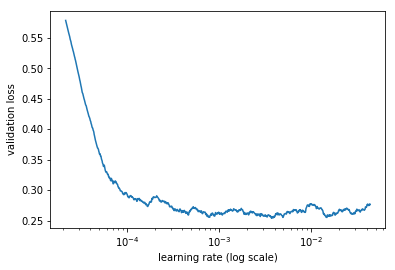

In [42]:
m.sched.plot(100)

In [48]:
lr=1e-5

#### Create the __AUC__ metric

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
def roc_auc_own(y_score, y_true):
    y_score = np.exp(y_score[:,1])
    return roc_auc_score(y_true, y_score)

In [49]:
m.fit(lr,5, metrics=[roc_auc_own])

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   roc_auc_own                   
    0      0.247421   0.249815   0.745494  
    1      0.253324   0.249741   0.745497                      
    2      0.244906   0.249645   0.745849                      
    3      0.253063   0.249815   0.745706                      
    4      0.249536   0.249659   0.745809                      



[array([ 0.24966]), 0.74580890782893694]

In [50]:
m.fit(lr, 3, cycle_len=1, metrics=[roc_auc_own])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   roc_auc_own                   
    0      0.244845   0.249721   0.745806  
    1      0.251903   0.249647   0.745895                      
    2      0.248606   0.249766   0.745916                      



[array([ 0.24977]), 0.74591561689070573]